# Trabajo Semenal 3 : Modelizando un ADC #

En esta tarea, usando lo practicado en clase , se modelizo un ADC para una señal senoidal contaminada con un nivel predeterminado de ruido.
Se uso con los parametros para la senoidal:
-   frecuencia f0 arbitraria, por ejemplo f0=fS/N=Δf
-   energía normalizada, es decir energía (o varianza) unitaria

Con respecto a los parámetros de la secuencia de ruido, diremos que:
-   será de carácter aditivo, es decir la señal que entra al ADC será sR=s+n. Siendo n la secuencia que simula la interferencia, y s la senoidal descrita anteriormente.
-   La potencia del ruido será Pn=kn.Pq W siendo el factor k una escala para la potencia del ruido de cuantización Pq=q212
-   finalmente, n será incorrelado y Gaussiano.
El ADC que deseamos simular trabajará a una frecuencia de muestreo fS=1000 Hz y tendrá un rango analógico de ±VF=2 Volts.

a. a) Generar el siguiente resultado producto de la experimentación. B = 4 bits,  kn=1

In [1]:
#Librerias
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
from scipy import signal
from scipy.fft import fft, fftshift

In [11]:
#Funciones
def mi_funcion_sen (vmax,dc,ff,ph,N,fs):
    
    ts = 1/fs # tiempo de muestreo o periodo
    tt=np.linspace (0, (N-1)*ts, N) #vector de tiempo

    xx= dc + vmax*np.sin(2*np.pi*ff*tt + ph)
    return tt, xx

def generar_senal_con_ruido(B,k):
    fs=1000 #Frecuencia de muestreo
    N=1000 #Cantidad de muestras
    f0=fs/N #Frecuencia arbitraria
    tt,xx=mi_funcion_sen(np.sqrt(2),0,f0,0,N,fs)

    xn=xx/np.std(xx) # Normalizo la señal senoidal

    Vf= 2 # rango simetrico o amplitud
    q= Vf/2**(B-1) #Pasos de cuantificacion de q Volts

    Pq=(q**2)/12 #potencia del ruido de cuantización
    Pn=k*Pq #Potencia de ruido

    nn=np.random.normal(0,np.sqrt(Pn),N) # Ruido analogico
    sr= xn + nn # Señal senoidal analogica mas ruido
    srq= np.round(sr/q) * q # Señal analogica mas ruido cuantizada
    nq= srq - sr # Ruido cuantizado

    return tt,xn,nn,sr,srq,nq,q

def graficar_senoidal(tt,xn,srq,sr):
    plt.figure(1)
    plt.figure(figsize=(10, 4))  # Aumenta el ancho del gráfico
    plt.plot(tt,srq,lw=2)
    plt.plot(tt,xn,color='orange', ls='dotted', label='$ s $ (sig.)' )
    plt.plot(tt,sr,color='green')
    plt.title('Señal muestrada por un ADC')
    plt.xlabel('Tiempo [t]')
    plt.ylabel('Voltaje [V]')   
    plt.show()

def graficar_frecuencia(xn,sr,srq,nq,nn):
    fs=1000 #Frecuencia de muestreo
    N=1000 #Cantidad de muestras
    f0=fs/N #Frecuencia arbitraria
    df = fs/N # resolución espectral

    plt.figure(2)
    plt.figure(figsize=(16, 4))  # Aumenta el ancho del gráfico

    ft_As = 1/N*np.fft.fft(xn) # Señal analogica normalizada, con la fft
    ft_SR = 1/N*np.fft.fft(sr) # Señal analogica con ruido, aplicada la fft
    ft_Srq = 1/N*np.fft.fft(srq) # Señal analogica con ruido quantizada, aplicada la fft
    ft_Nq = 1/N*np.fft.fft(nq) # piso de ruido digital
    ft_Nn = 1/N*np.fft.fft(nn) # Piso de ruido Analogico
    # grilla de sampleo frecuencial
    ff = np.linspace(0, (N-1)*df, N)

    bfrec = ff <= fs/2

    Nnq_mean = np.mean(np.abs(ft_Nq)**2) # ??
    nNn_mean = np.mean(np.abs(ft_Nn)**2) # ??

    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_As[bfrec])**2), color='orange', ls='dotted', label='$ s $ (sig.)' ) # Grafico de la señal senoidal analogica totalmente pura
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_SR[bfrec])**2), ':g', label='$ s_R = s + n $' ) # Grafico de la Señal analogica con ruido
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB'.format(10* np.log10(2* nNn_mean)) ) # Piso de ruido analogico
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$' ) # ?????'
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB'.format(10* np.log10(2* Nnq_mean)) ) # ????
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nn[bfrec])**2), ':r')
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Nq[bfrec])**2), ':c')
    plt.plot( np.array([ ff[bfrec][-1], ff[bfrec][-1] ]), plt.ylim(), ':k', label='BW', lw = 0.5  )
    plt.title('Respuesta en frecuencia')
    plt.ylabel('Densidad de Potencia [dB]')
    plt.xlabel('Frecuencia [Hz]')
    axes_hdl = plt.gca()
    axes_hdl.legend()
    plt.show()

def grafica_histograma(nq,q) :
    plt.figure(3)
    N=1000 #Cantidad de muestras
    bins = 10
    plt.hist(nq, bins=bins)
    plt.plot(np.array([-q/2, -q/2, q/2, q/2]),np.array([0, N/bins, N/bins, 0]), '--r' )
    plt.title( 'Ruido de cuantización para- q = {:5.5f} V'.format (q))
    plt.xlabel('Pasos de cuantización (q) [V]')
    plt.show()

<>:66: SyntaxWarning: invalid escape sequence '\o'
<>:67: SyntaxWarning: invalid escape sequence '\{'
<>:68: SyntaxWarning: invalid escape sequence '\o'
<>:66: SyntaxWarning: invalid escape sequence '\o'
<>:67: SyntaxWarning: invalid escape sequence '\{'
<>:68: SyntaxWarning: invalid escape sequence '\o'
C:\Users\Joaquin\AppData\Local\Temp\ipykernel_11452\1641223137.py:66: SyntaxWarning: invalid escape sequence '\o'
  plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB'.format(10* np.log10(2* nNn_mean)) ) # Piso de ruido analogico
C:\Users\Joaquin\AppData\Local\Temp\ipykernel_11452\1641223137.py:67: SyntaxWarning: invalid escape sequence '\{'
  plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, label='$ s_Q = Q_{B,V_F}\{s_R\}$' ) # ?????'
C:\Users\Joaquin\AppData\Local\Temp\ipykernel_11452\1641223137.py:68: SyntaxWarning: invalid escape sequence '\o'
  plt.plot( np.arra

<Figure size 640x480 with 0 Axes>

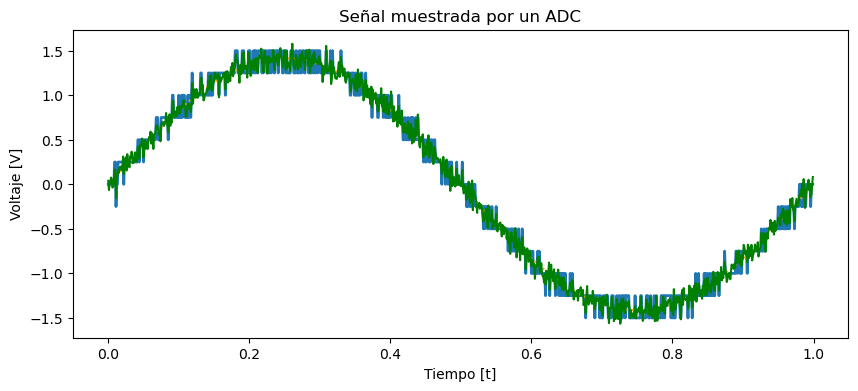

<Figure size 640x480 with 0 Axes>

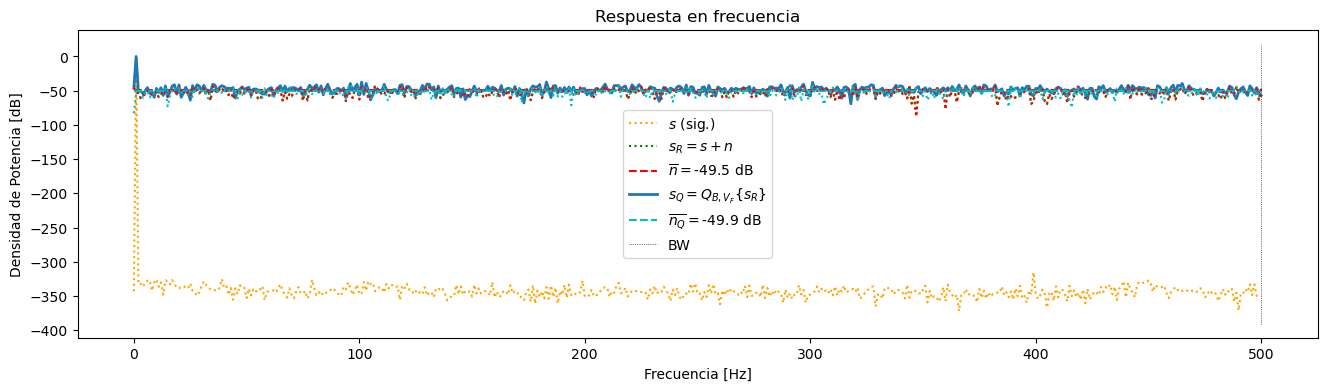

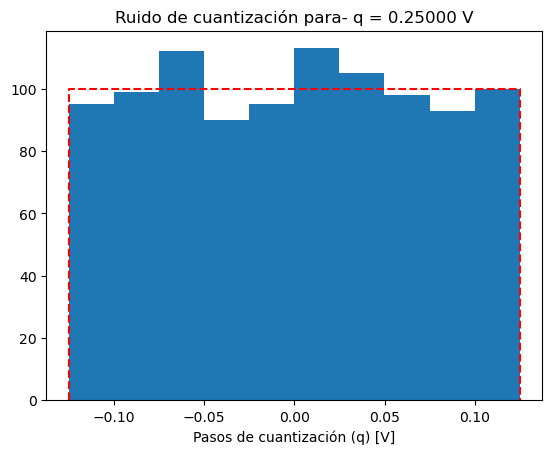

In [12]:
#experimento 1
tt_1,xn_1,nn_1,sr_1,srq_1,nq_1,q_1=generar_senal_con_ruido(4,1)
graficar_senoidal(tt_1,xn_1,srq_1,sr_1)
graficar_frecuencia(xn_1,sr_1,srq_1,nq_1,nn_1)
grafica_histograma(nq_1,q_1)

Analisis Experimento 1: Como se espera, la señal analogica contaminada presenta un ruido volumninoso, ya que al contener muy poca cantidad de bits, y al ser 1 su factor de escala su cuantizacion,su potencia de ruido sera notable a la hora de sumarse con la senoidal. Otra consecuencia de un valor bajo de bits es que la señal cuantizada presenta muy pocos niveles de cuantizacion ademas de que el ruido al estar tan presente, genera como una especie de señal deformada.

Siguiendo con los graficos, se puede notar a que todo la energia de la señal se encuentra en la frecuencia de 1Hz, tanto como la señal limpia, la sumada con ruido y la cuantificada, que es lo esperable y esta al estar normalizada presenta un valor de 1, que aplicando logaritmo resulta 0. Otras observaciones que se pueden notar es que los pisos de ruidos estan en el mismo nivel de decibeles, esto se lo atribuye al factor de escala al no afectar al valor de la potencia de ruido. Y Tambien podemos observar como las señales contaminadas ,luego de pasar por su pico, toman el nivel de su respectivo piso de ruido.

Para el tercer grafico, esta relacionado con el error al momento de cuantizar la señal donde esta se encuentra justamente en el intervalo -q/2 y q/2, como aplicamos una distribucion uniforme a ese ruido de cuantizacion vemos como este tiende a esa distribucion. 

<Figure size 640x480 with 0 Axes>

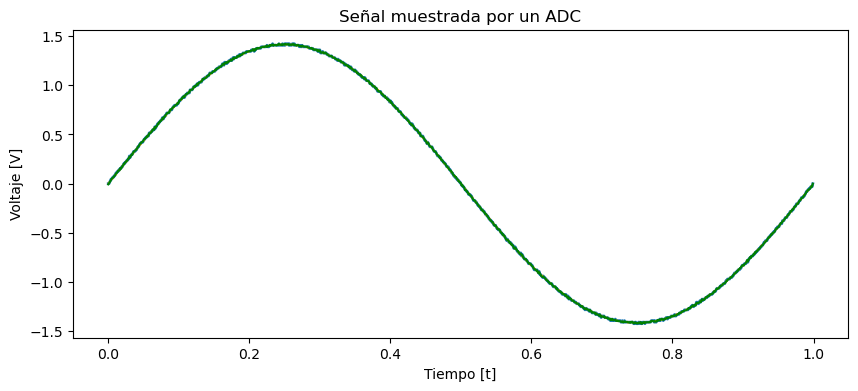

<Figure size 640x480 with 0 Axes>

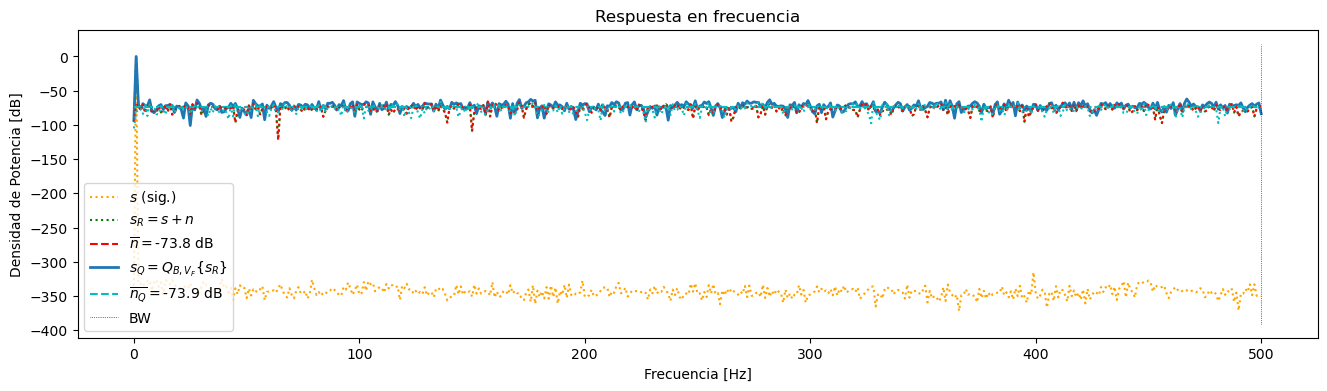

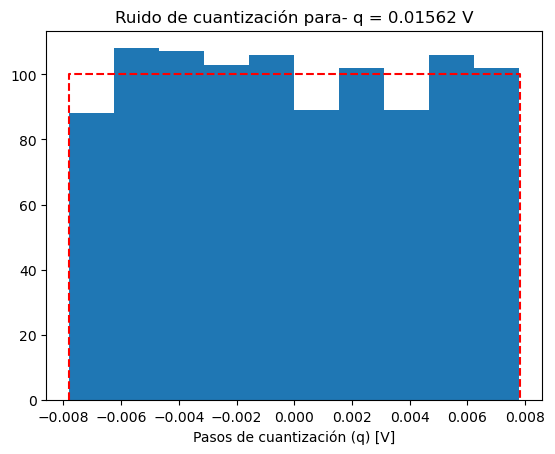

In [13]:
#experimento 2
tt_2,xn_2,nn_2,sr_2,srq_2,nq_2,q_2=generar_senal_con_ruido(8,1)
graficar_senoidal(tt_2,xn_2,srq_2,sr_2)
graficar_frecuencia(xn_2,sr_2,srq_2,nq_2,nn_2)
grafica_histograma(nq_2,q_2)

Analisis Experimento 2: Para 8 bits, al ser q mucho mas chico que para 4, el nivel de ruido contaminado no sera tan distinto, si bien es notable, no es tan abrupto como para 4. Luego la señal al tener mucho mas niveles para cuantificar, no se deforma la señal en comparacion a la que no esta contaminada.
En el grafico de frecuencia, no hay muchos cambios solo que los pisos de ruido disminuyeron aproximadamente 20 decadas, dejando en claro asi que este depende de la cantidad de niveles cuantificados. Siempre y cuando el factor de escala sea 1.

Con respecto al histograama vemos que este disminiyu en sus valores haciendo que cada vez un intervalo mucho mas corto, lo que permine un error menor y menos ruido de contaminacion de la señal, se nota que a medida que q se achica el error de este disminuye.

<Figure size 640x480 with 0 Axes>

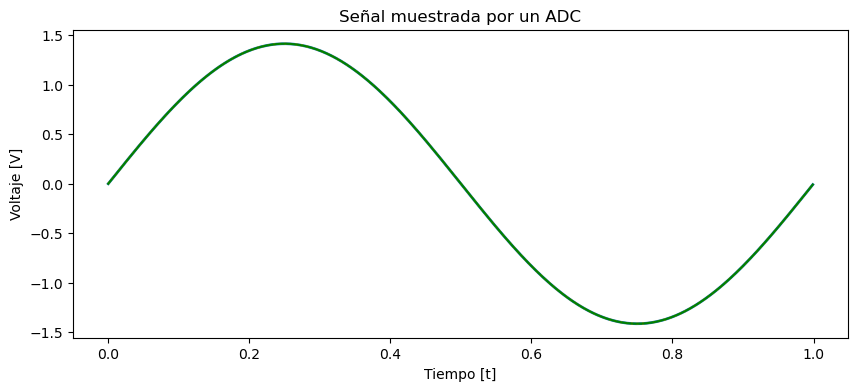

<Figure size 640x480 with 0 Axes>

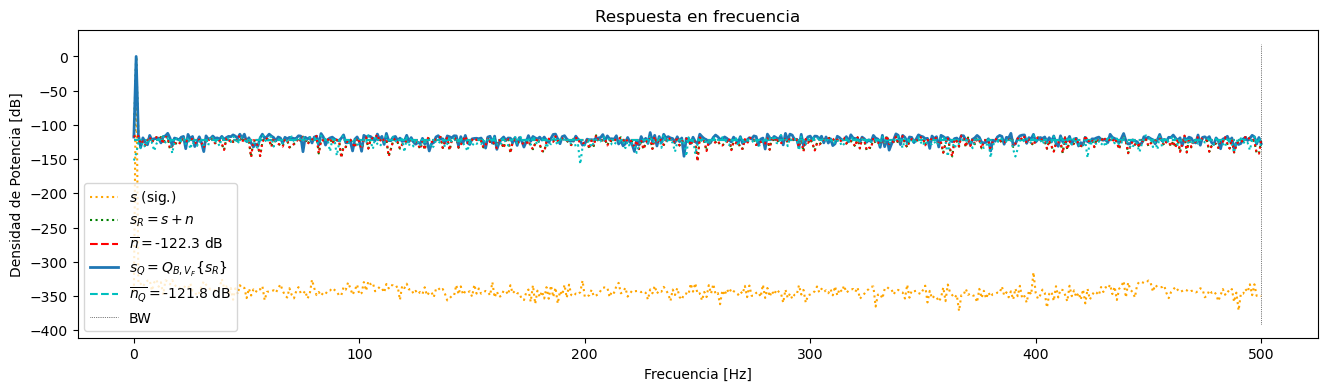

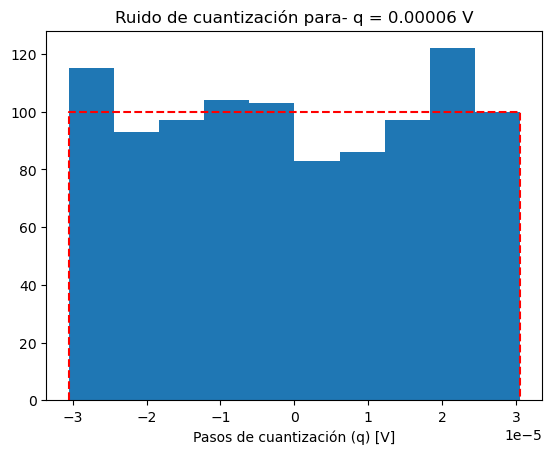

In [14]:
#Experimento 3
tt_3,xn_3,nn_3,sr_3,srq_3,nq_3,q_3=generar_senal_con_ruido(16,1)
graficar_senoidal(tt_3,xn_3,srq_3,sr_3)
graficar_frecuencia(xn_3,sr_3,srq_3,nq_3,nn_3)
grafica_histograma(nq_3,q_3)

Analisis Experimento 3: Para 16 bits, lo mas destacado esta en que le señal es mucho mas limpia y muy semejante a una senoidal. al tener un q de cuantificacion chico, el ruido generado es casi despreciable. 
Por otra parte los pisos de ruidos disminuyeron casi 50 decadas con respecto a 8, ya ese punto es casi nula la presencia de energia del ruido en la señal contaminada. En consecuencia de esto la señal culmina en una senoidal identificable

<Figure size 640x480 with 0 Axes>

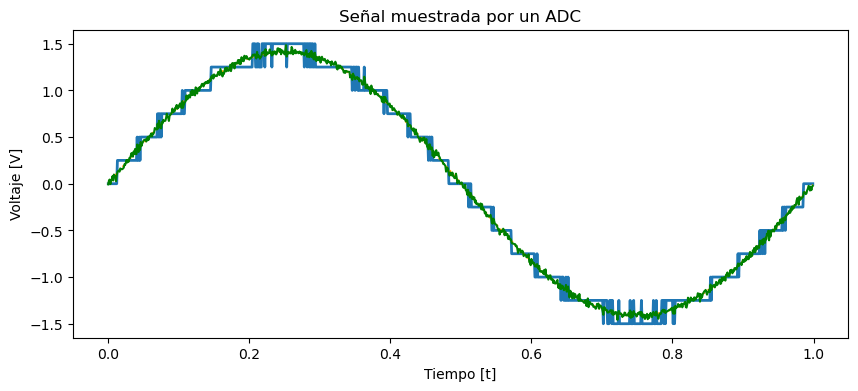

<Figure size 640x480 with 0 Axes>

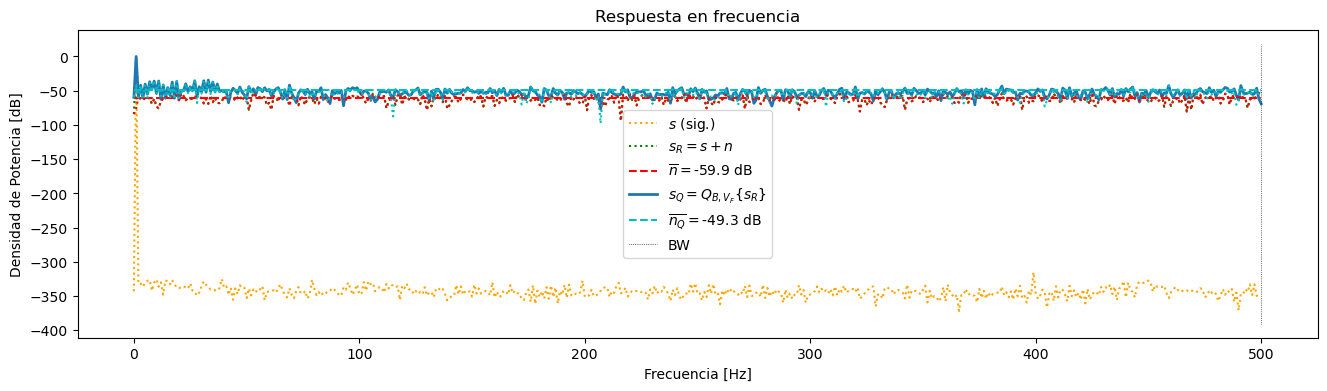

In [ ]:
#Experimento 4  
tt_4,xn_4,nn_4,sr_4,srq_4,nq_4,q_4=generar_senal_con_ruido(4,1/10)
graficar_senoidal(tt_4,xn_4,srq_4,sr_4)
graficar_frecuencia(xn_4,sr_4,srq_4,nq_4,nn_4)

Analisis Experimento 4: al cambiar el factor de escala, la contaminacion de ruido en el primer grafico disminuyo. Destacando asi la la señal cuantizada con pocos niveles. En contraparte notamos que,ya que este factor influye en la potencia, este al ser menor que uno se observa como el piso de ruido analogico disminuye diez decadas con respecto al piso de ruido cuantizado.

<Figure size 640x480 with 0 Axes>

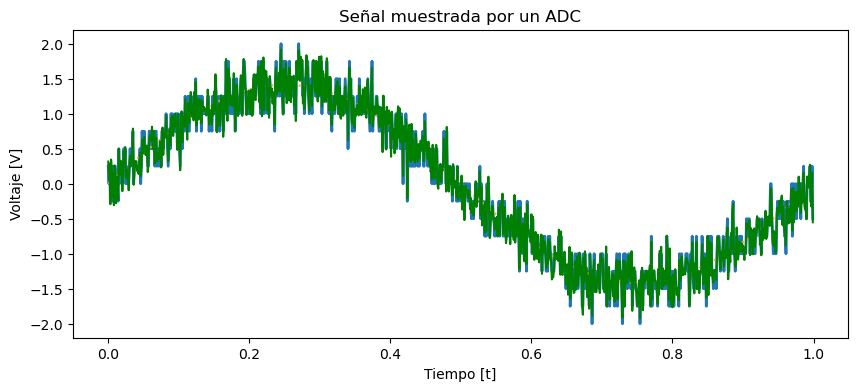

<Figure size 640x480 with 0 Axes>

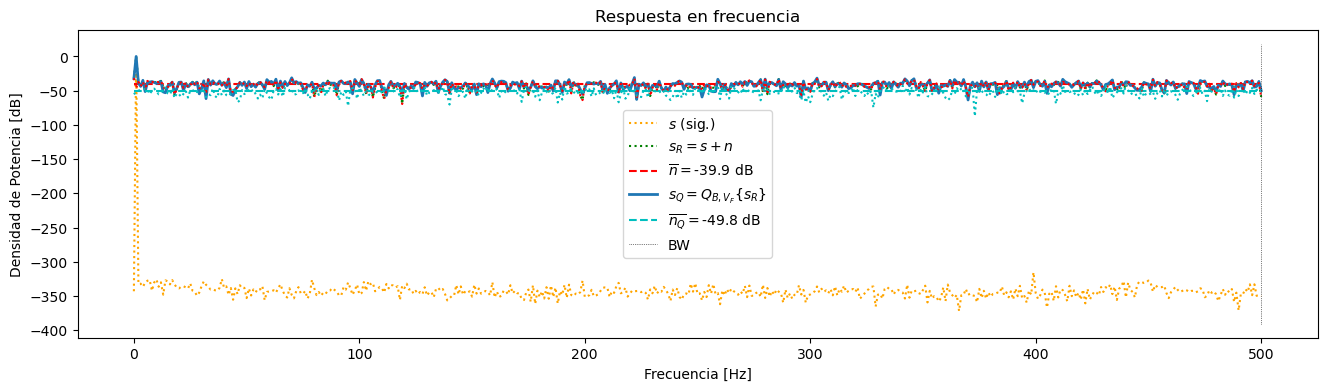

In [ ]:
#Experimento 5
tt_5,xn_5,nn_5,sr_5,srq_5,nq_5,q_5=generar_senal_con_ruido(4,10)
graficar_senoidal(tt_5,xn_5,srq_5,sr_5)
graficar_frecuencia(xn_5,sr_5,srq_5,nq_5,nn_5)

Analisis Experimento 5: Podemos ver que al aumentar el factor de escala a 10 veces mas grande, no solo que aumento el piso de ruido analogico 10 decadas con respecto al digital. Si no que en consecuencia de esto, al momento de cuantificar este tomara el ruido analagico como muestras visibles. Por esta razon se ve como la señal cuantificada es casi igual a la contaminada con ruido.


### Bonus:
La relacion establecida entre la cantidad de numeros de bits y la señal con ruido cuantizada, se establece en el piso de ruido establecido por la cantidad de numeros de bits, ya que este al aumentar uno desincremta cada 6 decadas el piso de ruido. Concluyendo asi que al aumentar esa cantidad llegamos a caonseguir una menor cantidad de ruido que contamina la señal.